In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
import copy
import ipython_bell

from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy.visualization import make_lupton_rgb

import lenstronomy.Util.param_util as param
import lenstronomy.Util.util as util
from lenstronomy.SimulationAPI.sim_api import SimAPI

In [2]:
DES_camera = {'read_noise': 7.,  # std of noise generated by read-out (in units of electrons)
               'pixel_scale': 0.2637,  # scale (in arcseconds) of pixels
               'ccd_gain': 6.  # electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
              }

DES_g_band_obs = {'exposure_time': 90.,  # exposure time per image (in seconds)
                   'sky_brightness': 35.01,  # sky brightness (in magnitude per square arcseconds)
                   'magnitude_zero_point': 30,  # magnitude in which 1 count per second per arcsecond square is registered (in ADU's)
                   'num_exposures': 7,  # number of exposures that are combined
                   'seeing': 1.12,  # full width at half maximum of the PSF (if not specific psf_model is specified)
                   'psf_type': 'GAUSSIAN',  # string, type of PSF ('GAUSSIAN' and 'PIXEL' supported)
                   'kernel_point_source': None  # 2d numpy array, model of PSF centered with odd number of pixels per axis (optional when psf_type='PIXEL' is chosen)
                  }

DES_r_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 34.7,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 7,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

DES_i_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 35.1,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 7,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

numpix = 46 # 

kwargs_g_band = util.merge_dicts(DES_camera, DES_g_band_obs)
kwargs_r_band = util.merge_dicts(DES_camera, DES_r_band_obs)
kwargs_i_band = util.merge_dicts(DES_camera, DES_i_band_obs)

kwargs_numerics = {'point_source_supersampling_factor': 1}

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

In [3]:
# Function to pick a random source center inside c% of the Einstein Radius of the lens
def pick_centers(kwargs_lens, c):
    radius = kwargs_lens['theta_E']
    c1, c2 = random.uniform(0, 1)*radius, random.uniform(0, 1)*radius
    d2 = c1**2 + c2**2
    while(d2 > c*radius**2):
        c1, c2 = random.uniform(0, 1)*radius, random.uniform(0, 1)*radius
        d2 = c1**2 + c2**2
    return c1, c2

In [4]:
#Writes 3 files for each simulation (one for each band). Folder is the ID, name n_g.fits
def write_files(ID, image_g, image_r, image_i):
    path = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/Sim/'
    folder = str(ID)
    if not os.path.exists(path + folder):
        os.makedirs(path + folder)
        n = 0
    else:
        n = len(os.listdir(path + folder))/3 #/3
    hdu = fits.PrimaryHDU(image_g)
    hdul = fits.HDUList([hdu])
    hdul.writeto(path + folder + '/' + str(int(n+1)) + '_g.fits')
    
    hdu = fits.PrimaryHDU(image_r)
    hdul = fits.HDUList([hdu])
    hdul.writeto(path + folder + '/' + str(int(n+1)) + '_r.fits')
    
    hdu = fits.PrimaryHDU(image_i)
    hdul = fits.HDUList([hdu])
    hdul.writeto(path + folder + '/' + str(int(n+1)) + '_i.fits')

In [5]:
# Color distribution
colors = pd.read_csv('color_distribution/source_colors.csv')
colors = colors[colors['DNF_ZMEAN_MOF'] > 0.01] #When there is no data z<0
colors = colors[colors['MAG_PSF_G'] < 30.] [colors['MAG_PSF_R'] < 30.] [colors['MAG_PSF_I'] < 30.] #decent magnitude
colors['g_r'] = colors['MAG_PSF_G'] - colors['MAG_PSF_R'] # g-r color
colors['r_i'] = colors['MAG_PSF_R'] - colors['MAG_PSF_I'] # r-i color

dz = 0.1 # Range of redshift for filtering
dm = 0.2 # Range of magnitude for filtering

def magnitude_and_color_distribution(z, mmin = 20, mmax = 26):
    #objects with a redshift between z - dz and z + dz, same idea for apparent magnitude
    fcolors = colors[(colors['DNF_ZMEAN_MOF'] > z - dz)] [(colors['DNF_ZMEAN_MOF'] < z + dz)] 
    #getting a realistic magnitude for this redshift
    m = fcolors.sample()['MAG_PSF_G'].values[0]
    while(m > mmax or m < mmin):
        m = fcolors.sample()['MAG_PSF_G'].values[0]
    fcolors = fcolors[(colors['MAG_PSF_G'] > m - dm)] [(colors['MAG_PSF_G'] < m + dm)]
    random_object = fcolors.sample()
    m = random_object['MAG_PSF_G'].values[0]
    g_r = random_object['g_r'].values[0]
    r_i = random_object['r_i'].values[0]
    return(m, g_r, r_i)

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [6]:
def simulation(redshifts, sigma, lens_ellip, magnitudes, double, i, cut_E, c):
   
    kwargs_model_physical = {'lens_model_list': ['SIE'],  # list of lens models to be used
                          'lens_redshift_list': [redshifts['lens']],  # list of redshift of the deflections
                          # list of extended source models to be used
                          'source_light_model_list': ['SERSIC_ELLIPSE'],  
                          # list of redshfits of the sources in same order as source_light_model_list
                          'source_redshift_list': [redshifts['source1']],  
                          'cosmo': cosmo,  # astropy.cosmology instance
                          # redshift of the default source (if not further specified by 'source_redshift_list')
                          'z_source': redshifts['source2']} 
                           #and also serves as the redshift of lensed point sources}

    if(double == True):
        kwargs_model_physical['source_light_model_list'].append('SERSIC')
        kwargs_model_physical['source_redshift_list'].append(redshifts['source2'])
        
    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)
    sim_r = SimAPI(numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model_physical)
    sim_i = SimAPI(numpix=numpix, kwargs_single_band=kwargs_i_band, kwargs_model=kwargs_model_physical)
    
    imSim_g = sim_g.image_model_class(kwargs_numerics)
    imSim_r = sim_r.image_model_class(kwargs_numerics)
    imSim_i = sim_i.image_model_class(kwargs_numerics)

    #lens mass model
    kwargs_mass = [{'sigma_v': sigma, 'center_x': 0, 'center_y': 0, 
                    'e1': lens_ellip[0], 'e2': lens_ellip[1]}]
    kwargs_lens = sim_g.physical2lensing_conversion(kwargs_mass=kwargs_mass)
    #cut on the Einstein radius of the lens
    if(kwargs_lens[0]['theta_E'] < cut_E):
        return None
    
    #First source light distributions & colors of the other bands for each source
    m1, g_r_source_1, r_i_source_1 = magnitude_and_color_distribution(redshifts['source1'], mmin = magnitudes['m1_min'], mmax = magnitudes['m1_max1'])
    r1, n1 = random.uniform(0.2, 0.4), random.uniform(1.2, 1.7)
    #Pick center of first source inside the c% of the lens Einstein Radius
    #c = 1 if double else 0.9
    c1x, c1y = pick_centers(kwargs_lens[0], c)
    #First source light:
    kwargs_source_mag_g_1 = [{'magnitude': m1, 'R_sersic': r1, 'n_sersic': n1, 'e1': 0., 'e2': 0.,
                              'center_x': c1x, 'center_y': c1y}]
    #Adding color distribution to the bands (first source):
    kwargs_source_mag_r_1 = copy.deepcopy(kwargs_source_mag_g_1)
    kwargs_source_mag_r_1[0]['magnitude'] -= g_r_source_1
    kwargs_source_mag_i_1 = copy.deepcopy(kwargs_source_mag_r_1)
    kwargs_source_mag_i_1[0]['magnitude'] -= r_i_source_1
    #Same for second source
    if(double == True):
        m2, g_r_source_2, r_i_source_2 = magnitude_and_color_distribution(redshifts['source2'], mmin = m1, mmax = magnitudes['m2_max'])
        r2, n2 = random.uniform(0.2, 0.4), random.uniform(1.2, 1.7)
        c2x, c2y = pick_centers(kwargs_lens[0], c)
        kwargs_source_mag_g_2 = [{'magnitude': m2, 'R_sersic': r2, 'n_sersic': n2, 
                              'center_x': c2x, 'center_y': c2y}]
        kwargs_source_mag_r_2 = copy.deepcopy(kwargs_source_mag_g_2)
        kwargs_source_mag_r_2[0]['magnitude'] -= g_r_source_2
        kwargs_source_mag_i_2 = copy.deepcopy(kwargs_source_mag_r_2)
        kwargs_source_mag_i_2[0]['magnitude'] -= r_i_source_2
        
    kwargs_source_mag_g = kwargs_source_mag_g_1 + kwargs_source_mag_g_2 if(double) else kwargs_source_mag_g_1 
    kwargs_source_mag_r = kwargs_source_mag_r_1 + kwargs_source_mag_r_2 if(double) else kwargs_source_mag_r_1 
    kwargs_source_mag_i = kwargs_source_mag_i_1 + kwargs_source_mag_i_2 if(double) else kwargs_source_mag_i_1 
    
    kwargs_lens_light_g, kwargs_source_g , point = sim_g.magnitude2amplitude(kwargs_lens_light_mag=None, 
                                                    kwargs_source_mag=kwargs_source_mag_g, kwargs_ps_mag=None)
    kwargs_lens_light_r, kwargs_source_r , point = sim_r.magnitude2amplitude(kwargs_lens_light_mag=None, 
                                                    kwargs_source_mag=kwargs_source_mag_r, kwargs_ps_mag=None)
    kwargs_lens_light_i, kwargs_source_i , point = sim_i.magnitude2amplitude(kwargs_lens_light_mag=None, 
                                                    kwargs_source_mag=kwargs_source_mag_i, kwargs_ps_mag=None)
    
    image_g = imSim_g.image(kwargs_lens, kwargs_source_g)
    image_r = imSim_r.image(kwargs_lens, kwargs_source_r)
    image_i = imSim_i.image(kwargs_lens, kwargs_source_i)
    
    image_g += sim_g.noise_for_model(model=image_g)
    image_r += sim_r.noise_for_model(model=image_r)
    image_i += sim_i.noise_for_model(model=image_i)
    
    image_g = image_g[::-1]
    image_r = image_r[::-1]
    image_i = image_i[::-1]
    
    write_files(i, image_g, image_r, image_i)  
    
    #"""
    rgb = make_lupton_rgb(np.log10(image_g), np.log10(image_r), np.log10(image_i), Q=2., stretch=4.)
    plt.figure()
    plt.imshow(rgb)
    plt.xticks([], [])
    plt.yticks([], [])
    #plt.savefig('Image' + str(i) + '.png', bbox_inches='tight')
    plt.show(block=True)
    #plt.close()
    #"""

In [7]:
complete_data = pd.read_csv('Data/all_data_sim.csv')
print(len(complete_data))
data = complete_data.sample(n = 500, replace = True) 
data.head(2)

19727


,COADD_OBJECT_ID,PIXEL,RA,DEC,SOF_CM_G_1,SOF_CM_G_2,Z,VEL_DISP,FWHM_WMEAN_G,FWHM_WMEAN_R,FWHM_WMEAN_I
13366,243897618,74470951,24.763523,2.324231,-0.026295,0.223220,0.337183,226.20126,1.11668,0.964135,0.932746
15401,304940901,73731768,19.407565,-1.468099,-0.070121,0.050172,0.384382,210.99220,1.16537,1.055670,0.878768


In [8]:
def simulations_from_data(num_max, double):
    complete_data = pd.read_csv('Data/all_data_sim.csv')
    data = complete_data.sample(frac=1).reset_index() #(n = 30000, replace = True)
    for index, row in data.iterrows():
        if index == num_max:
            break
        DES_g_band_obs['seeing'] = row['FWHM_WMEAN_G'] 
        DES_r_band_obs['seeing'] = row['FWHM_WMEAN_R']
        DES_i_band_obs['seeing'] = row['FWHM_WMEAN_I']
        
        coadd_id = int(row['COADD_OBJECT_ID'])
        z_lens = row['Z']
        z_source1 = random.uniform(z_lens, z_lens + 0.3) # 0.35, 0.7
        z_source2 = random.uniform(z_source1, z_source1 + 0.35) # 0.35
        redshifts = {'lens': z_lens, 'source1': z_source1, 'source2': z_source2}
        dispersion = row['VEL_DISP']
        #m1_max random:
        magnitudes = {'m1_min': 20., 'm1_max1':24.5, 'm2_max':26} #23.9, 26
        c = 0.75
        cut_E = 0.55
    
        angle, ratio = param.ellipticity2phi_q(row['SOF_CM_G_1'], row['SOF_CM_G_2'])
        angle += 0.698132*random.uniform(-1, 1) #noise between -40 and 40 degrees
        ratio = random.uniform(0.001, 1) #distribution for the axis ratio
        e1, e2 = param.phi_q2_ellipticity(angle, ratio)
        lens_ellip = [e1, e2]
    
        simulation(redshifts, dispersion, lens_ellip, magnitudes, double , coadd_id, cut_E, c)

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in log10


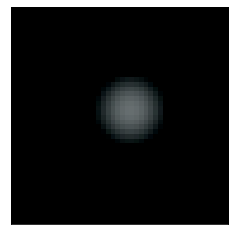

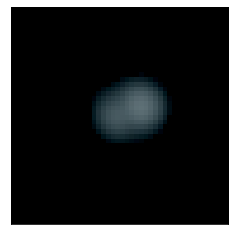

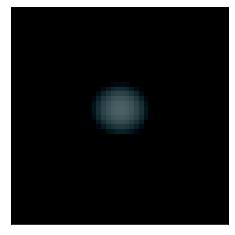

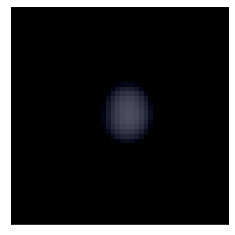

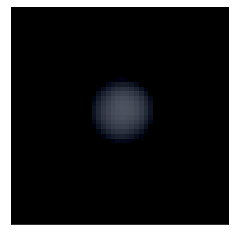

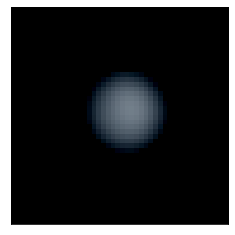

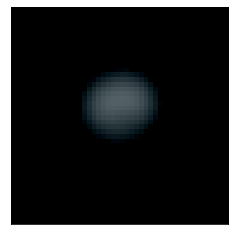

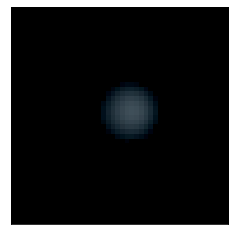

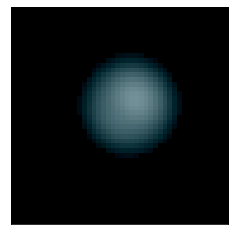

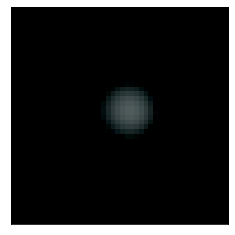

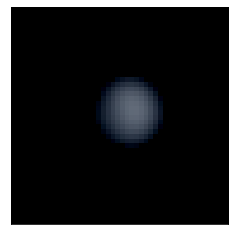

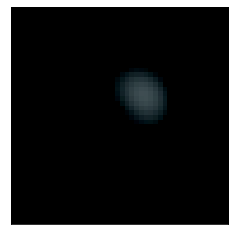

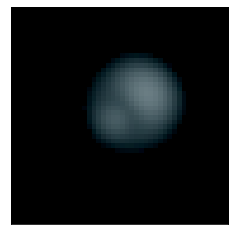

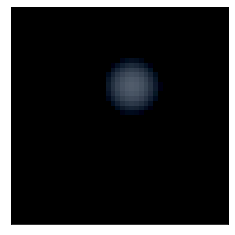

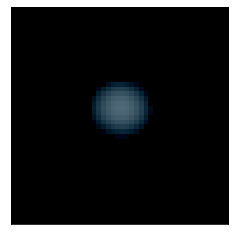

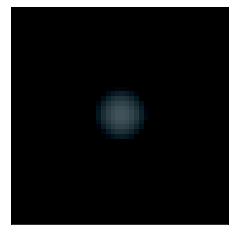

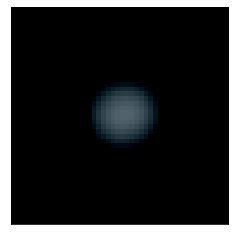

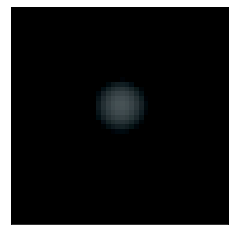

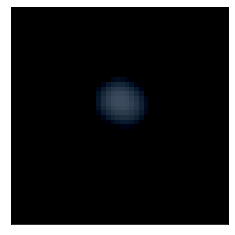

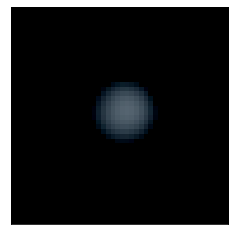

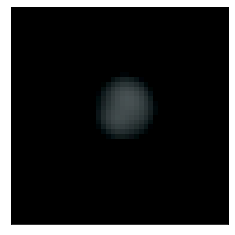

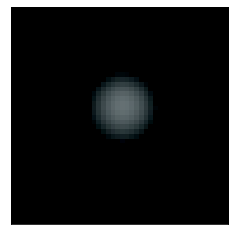

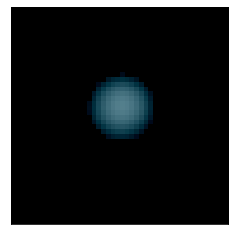

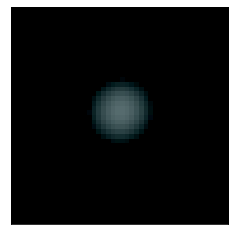

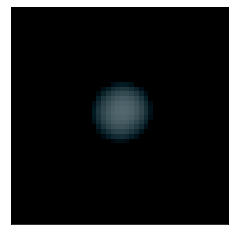

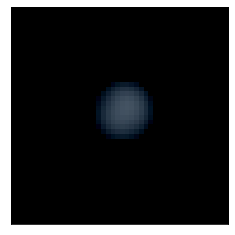

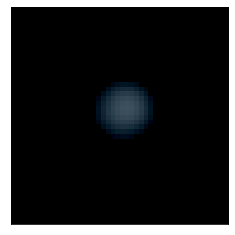

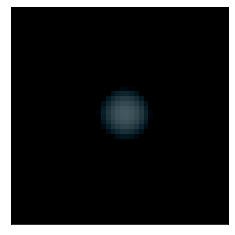

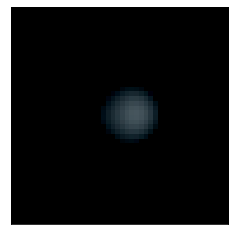

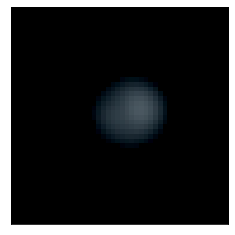

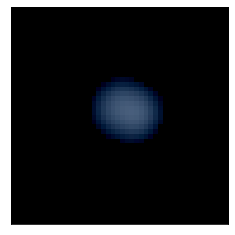

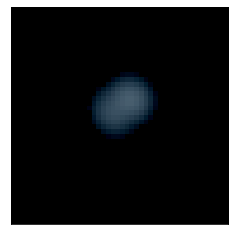

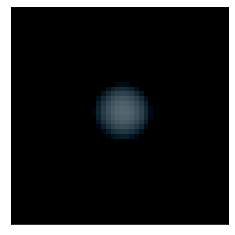

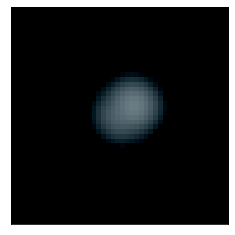

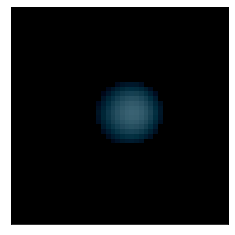

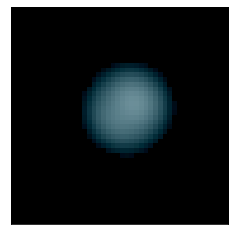

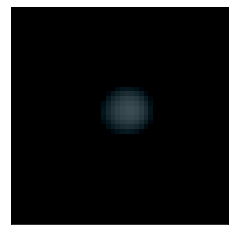

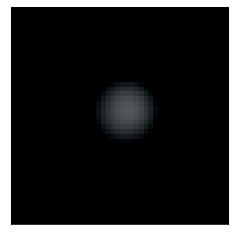

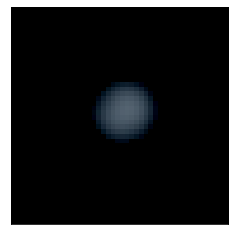

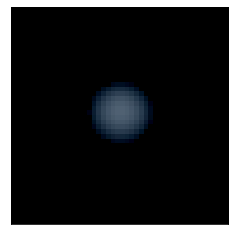

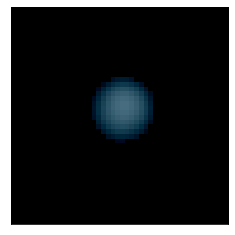

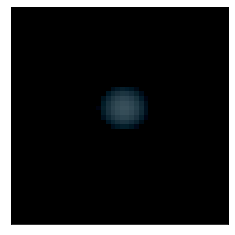

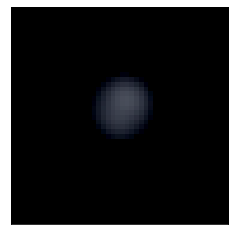

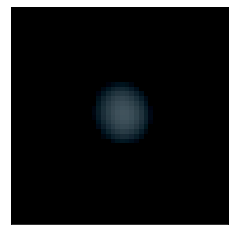

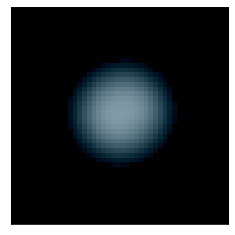

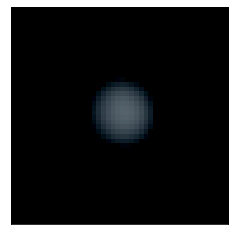

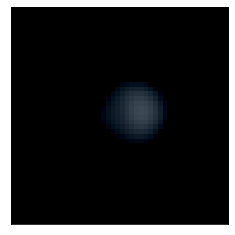

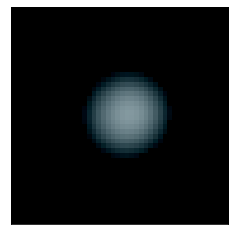

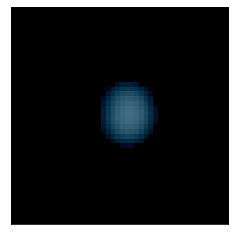

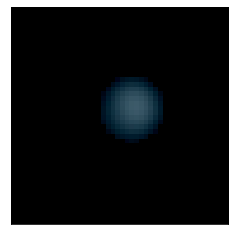

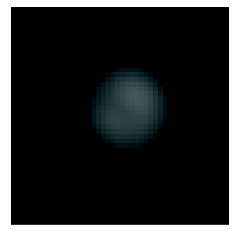

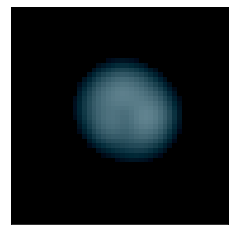

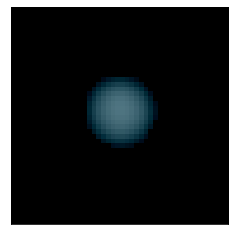

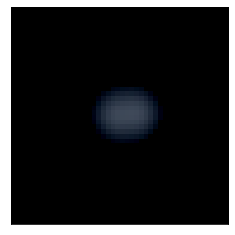

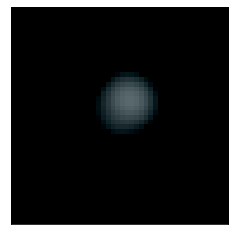

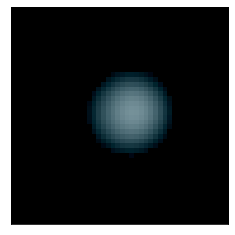

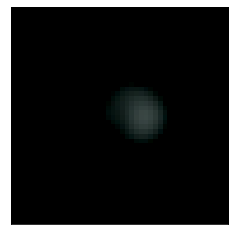

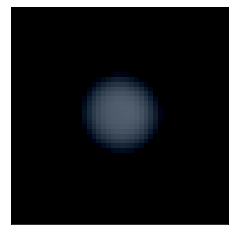

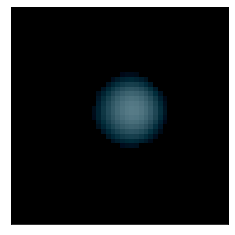

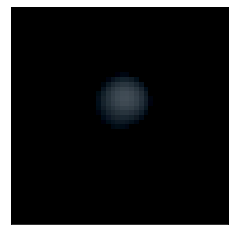

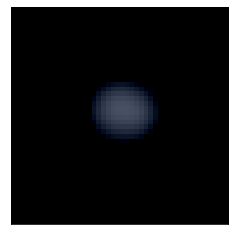

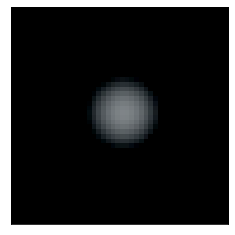

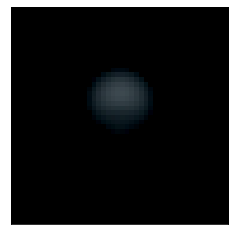

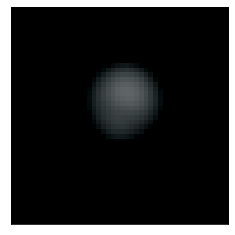

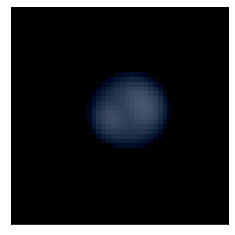

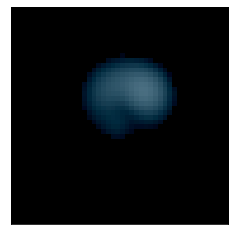

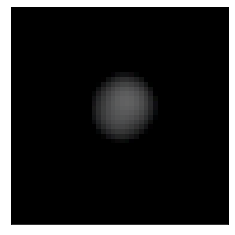

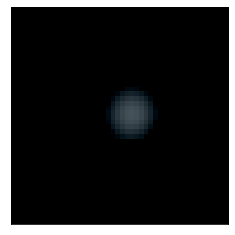

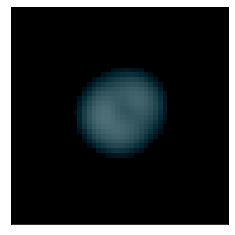

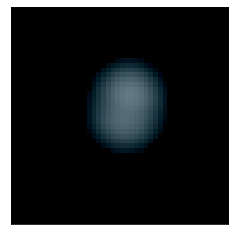

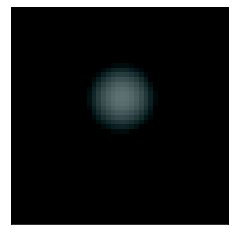

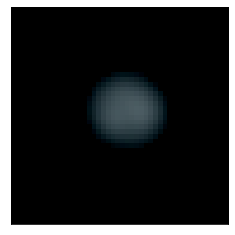

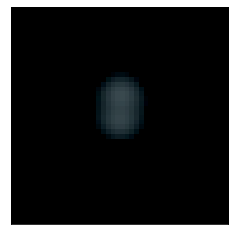

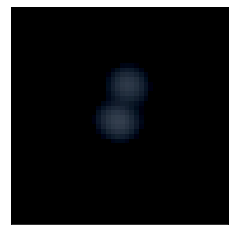

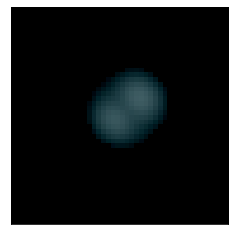

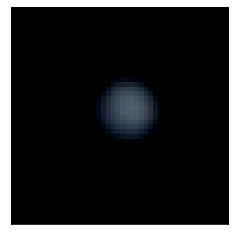

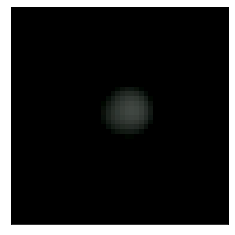

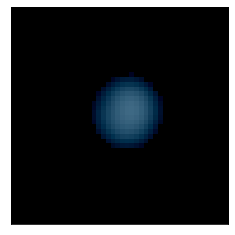

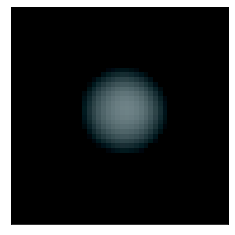

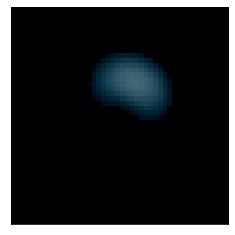

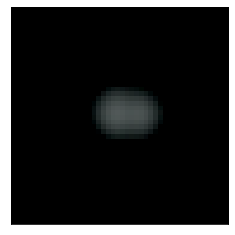

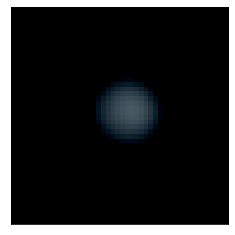

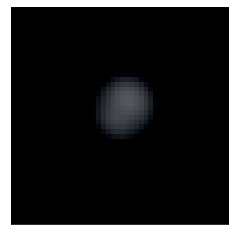

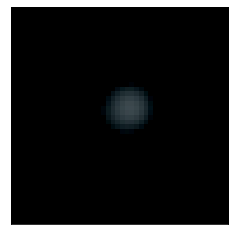

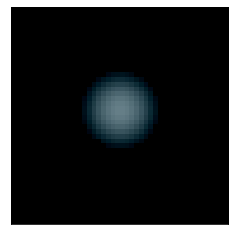

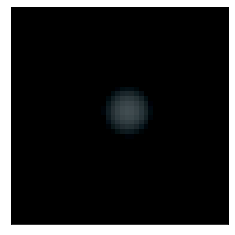

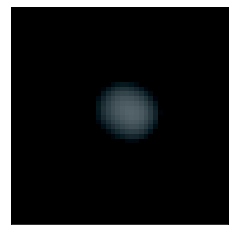

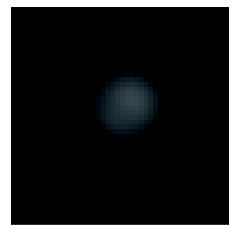

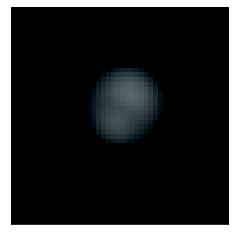

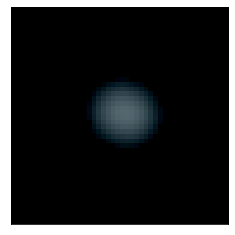

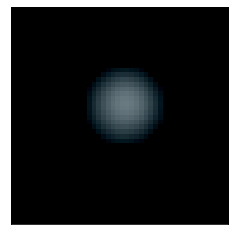

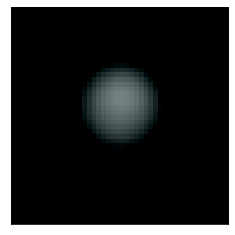

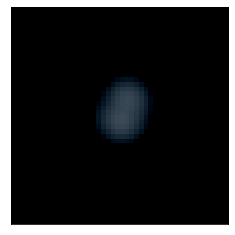

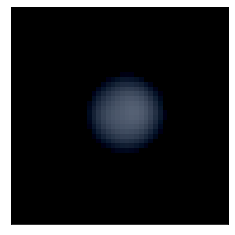

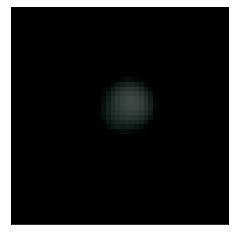

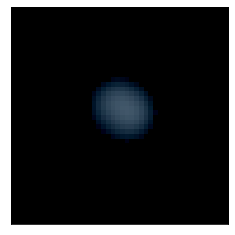

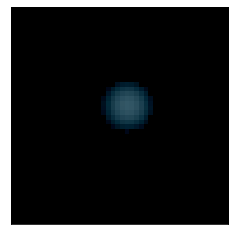

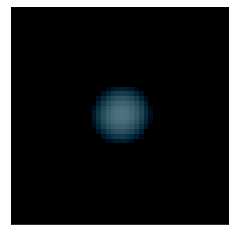

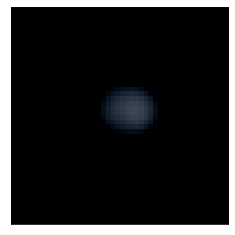

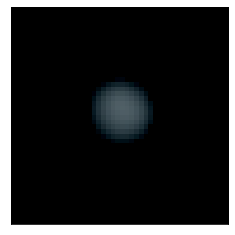

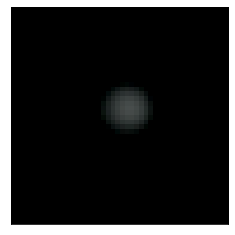

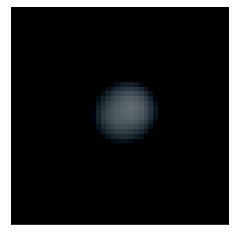

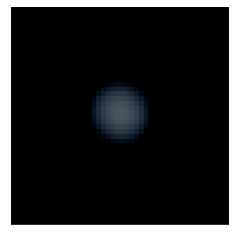

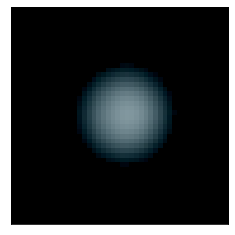

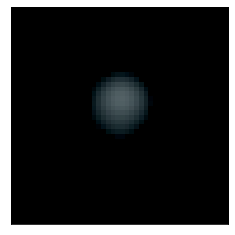

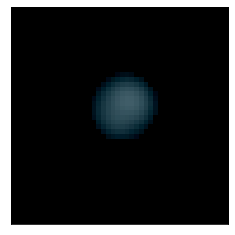

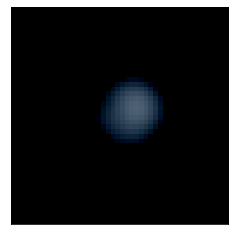

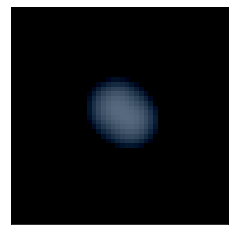

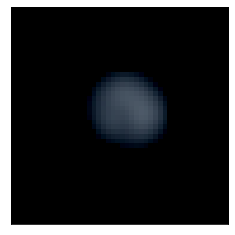

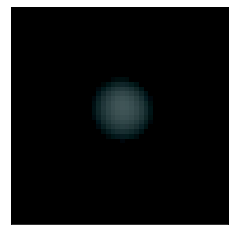

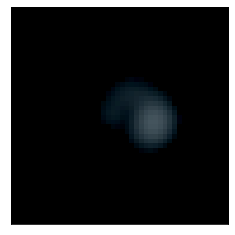

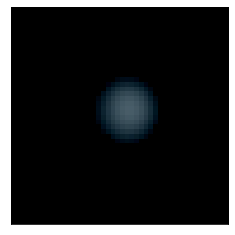

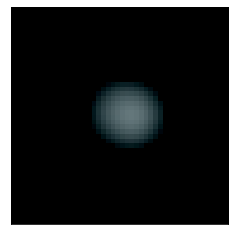

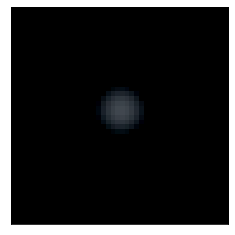

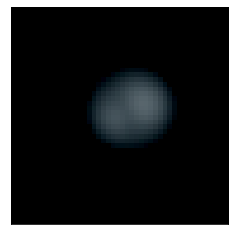

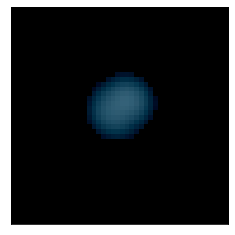

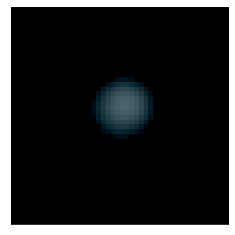

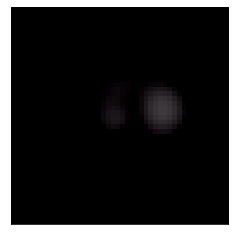

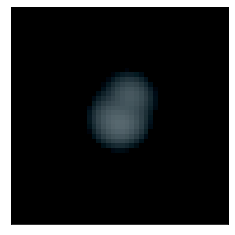

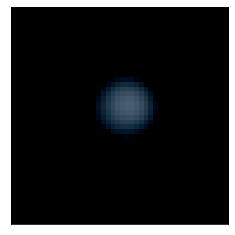

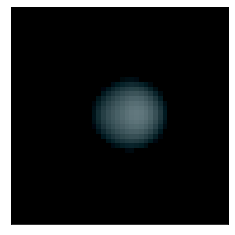

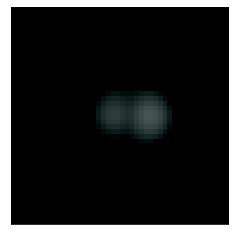

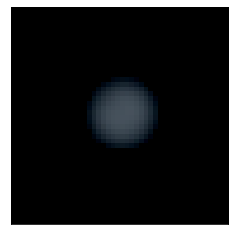

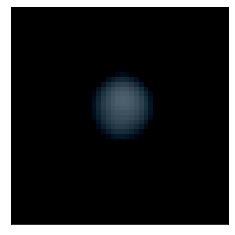

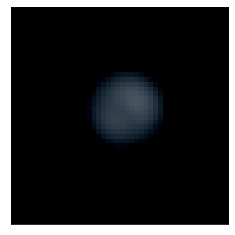

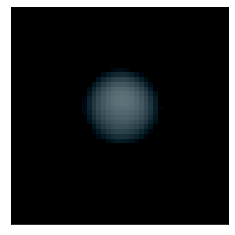

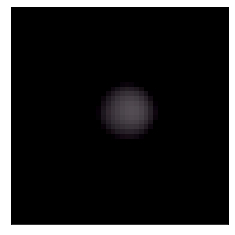

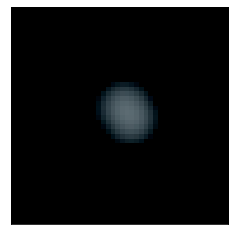

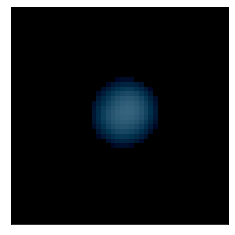

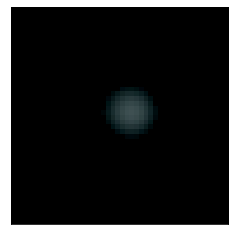

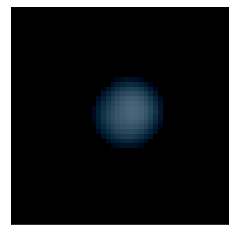

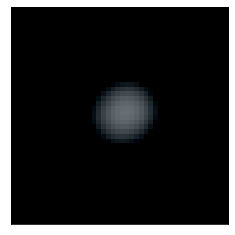

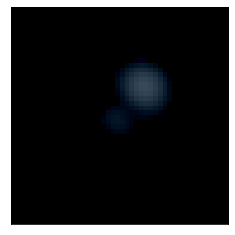

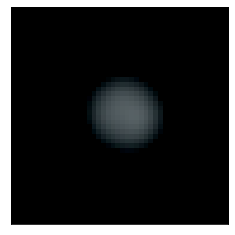

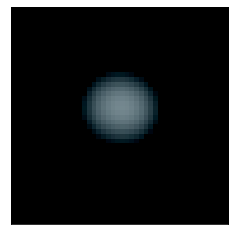

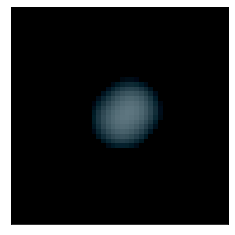

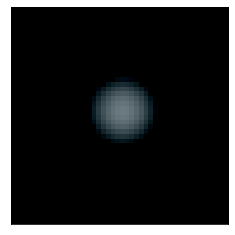

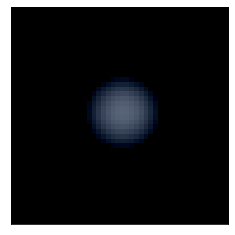

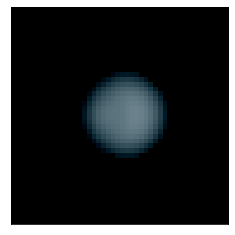

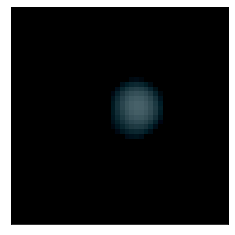

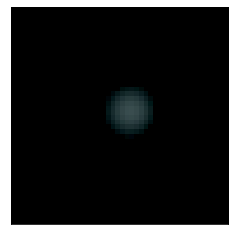

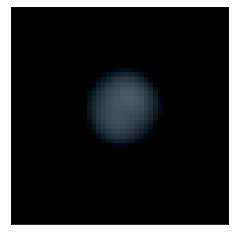

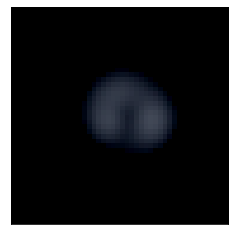

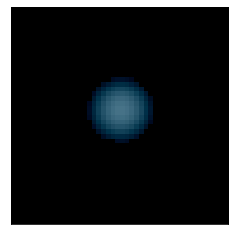

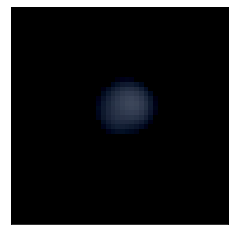

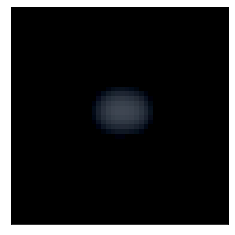

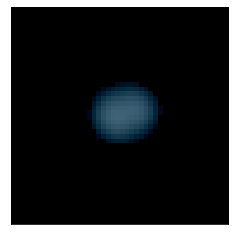

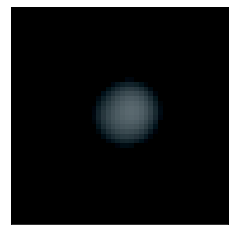

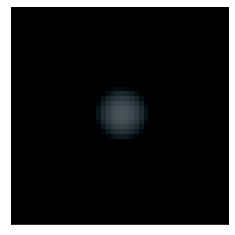

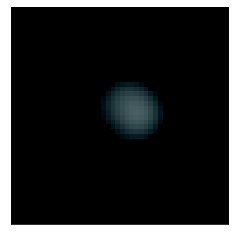

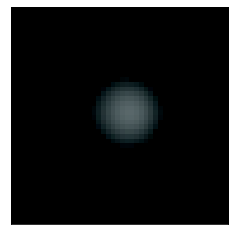

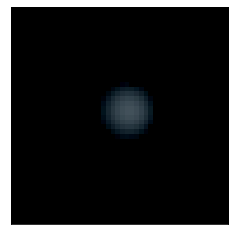

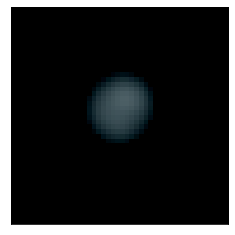

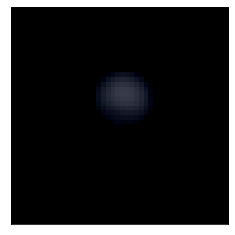

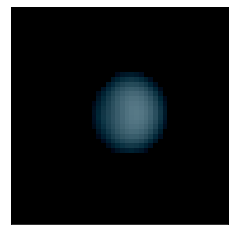

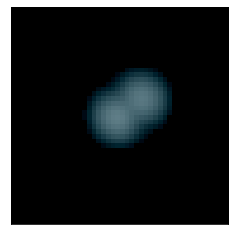

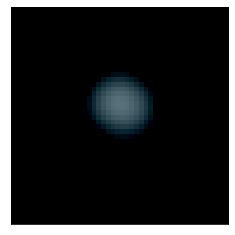

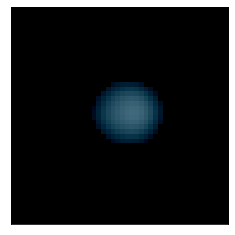

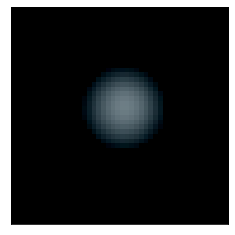

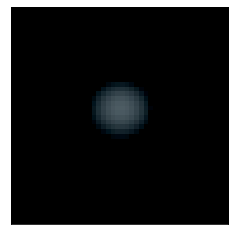

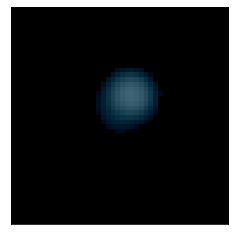

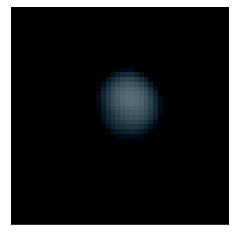

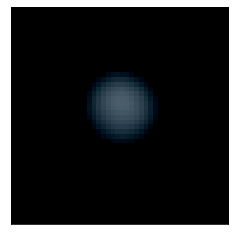

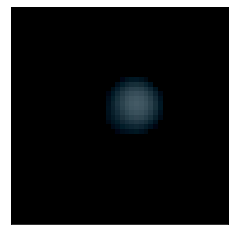

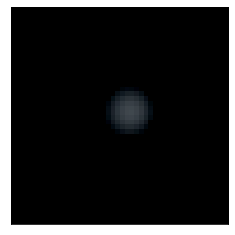

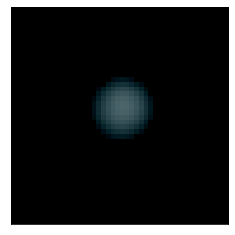

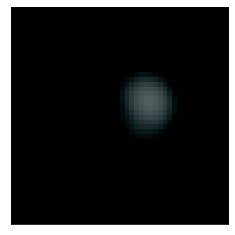

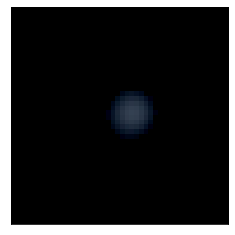

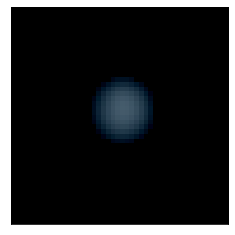

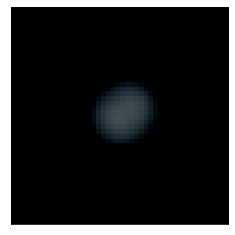

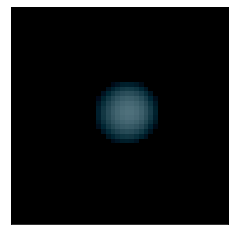

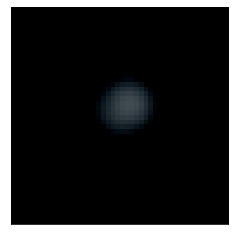

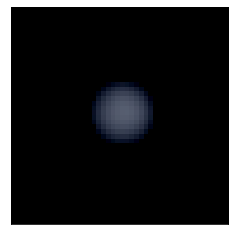

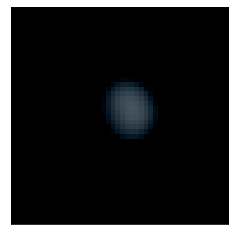

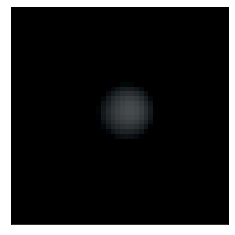

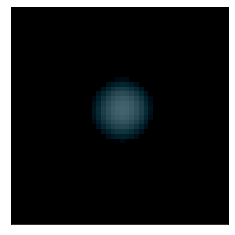

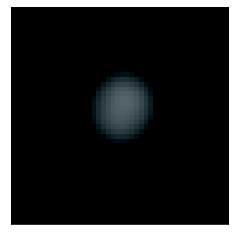

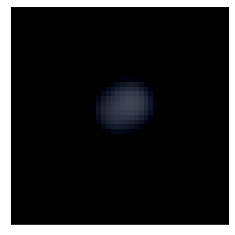

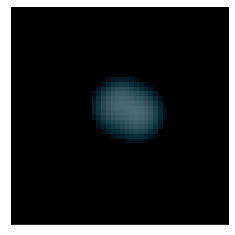

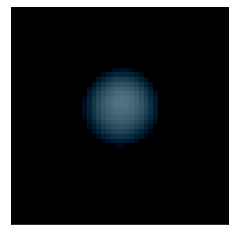

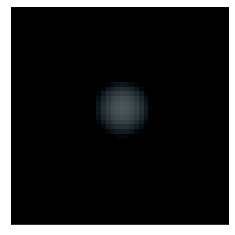

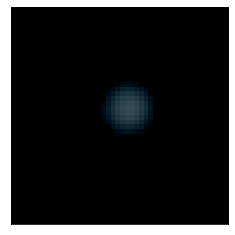

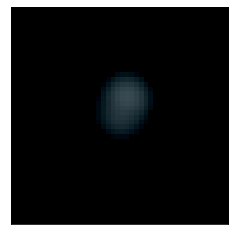

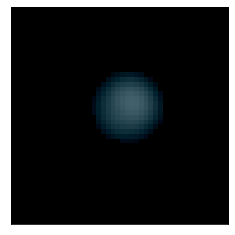

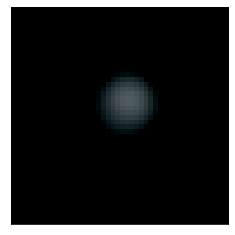

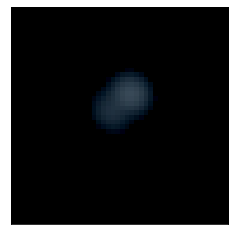

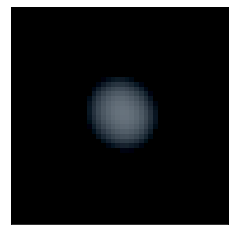

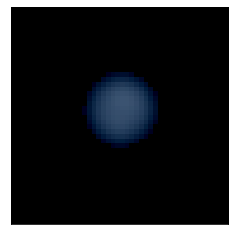

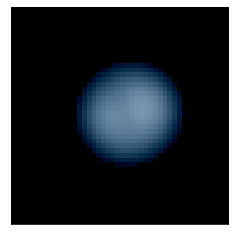

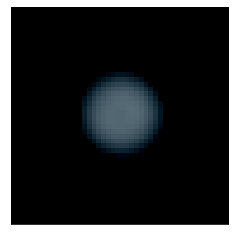

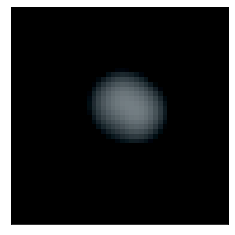

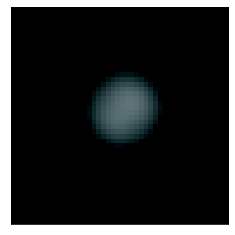

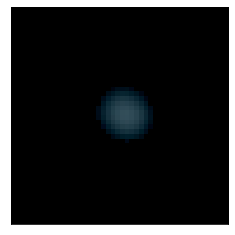

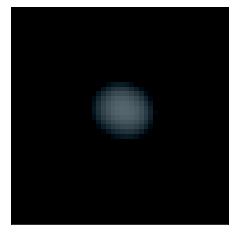

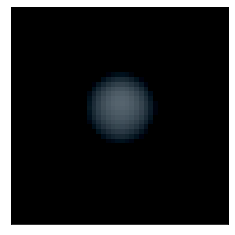

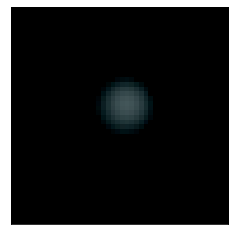

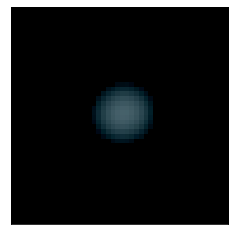

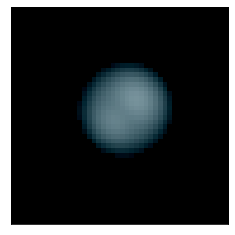

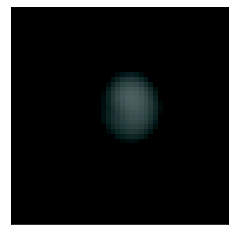

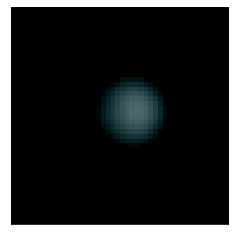

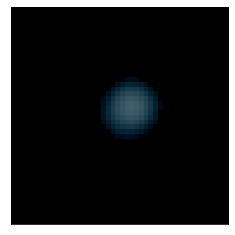

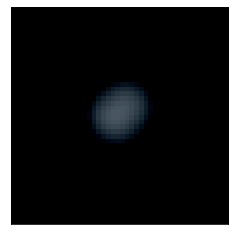

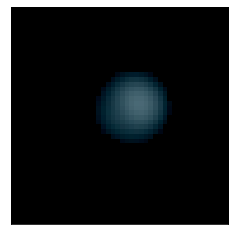

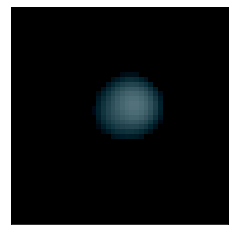

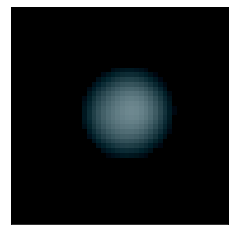

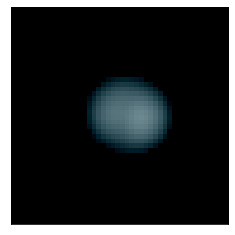

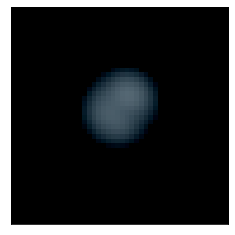

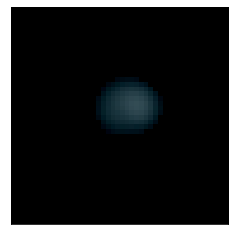

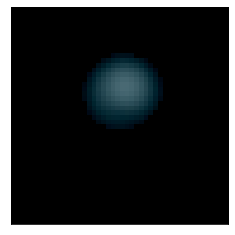

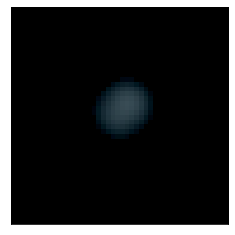

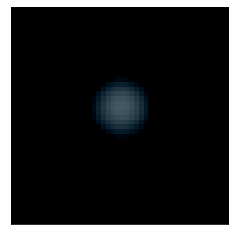

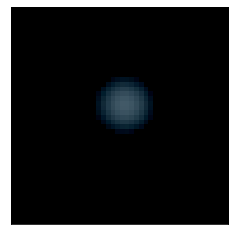

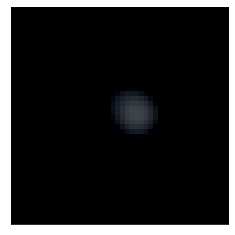

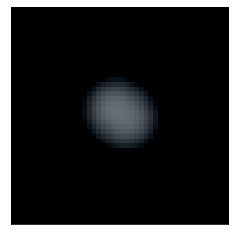

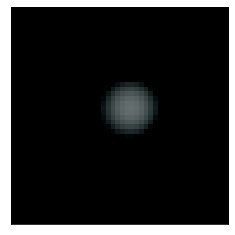

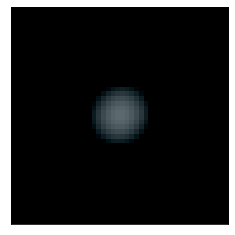

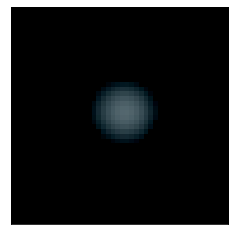

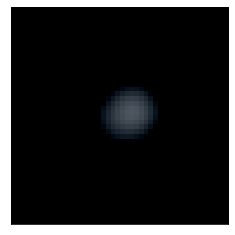

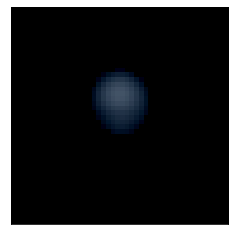

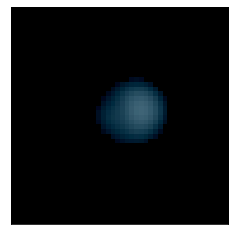

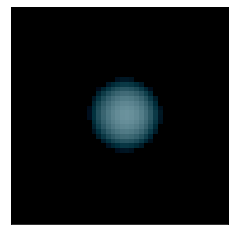

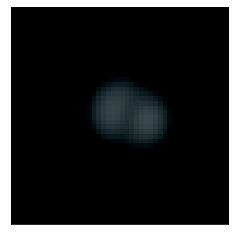

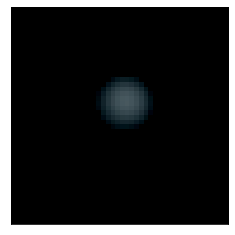

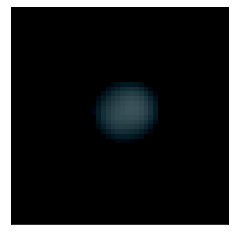

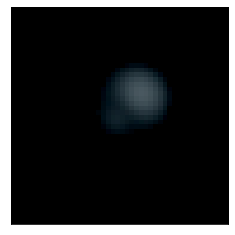

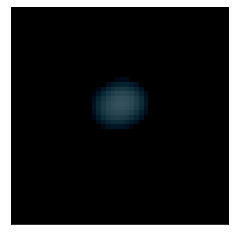

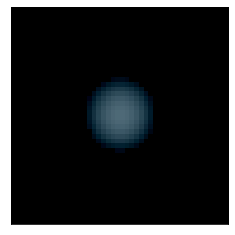

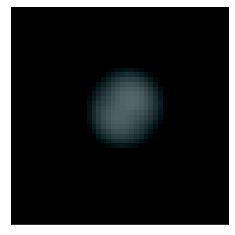

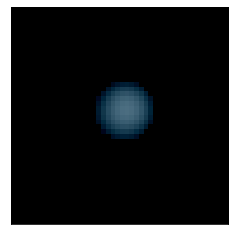

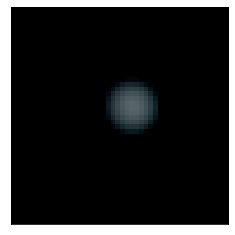

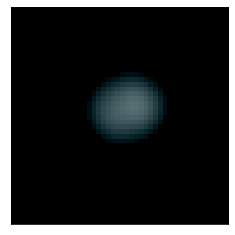

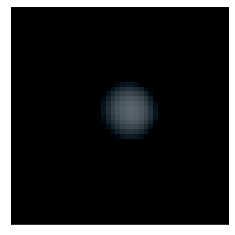

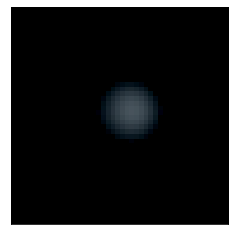

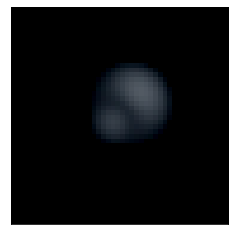

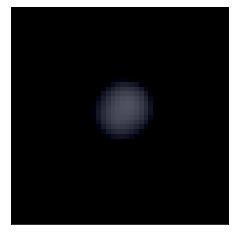

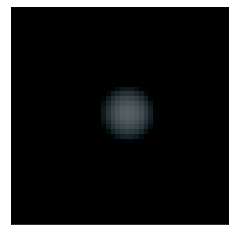

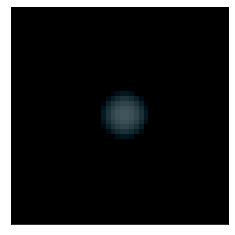

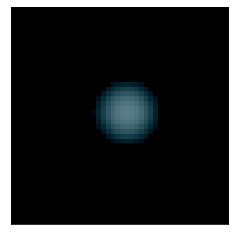

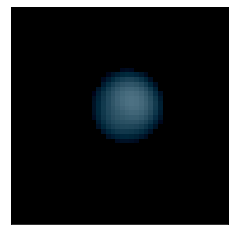

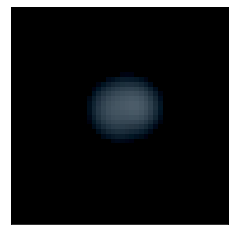

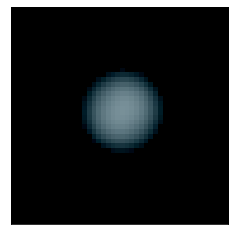

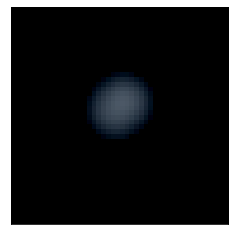

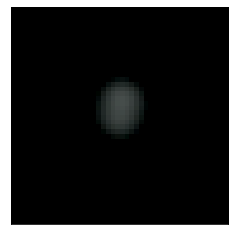

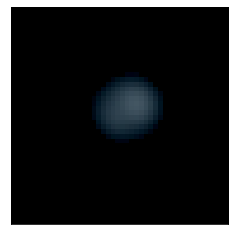

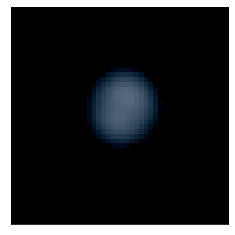

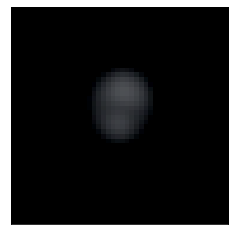

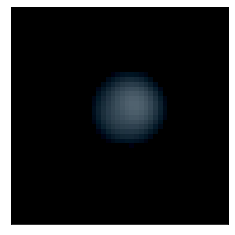

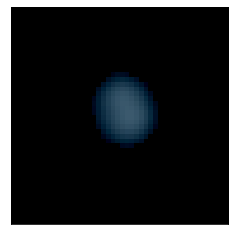

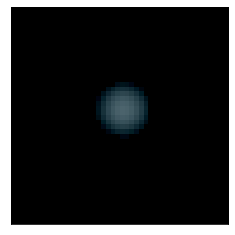

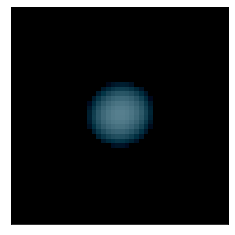

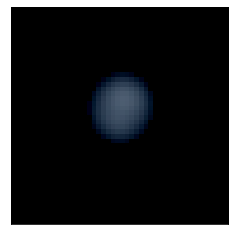

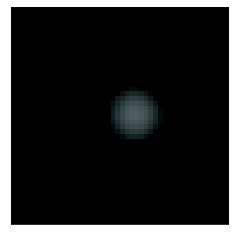

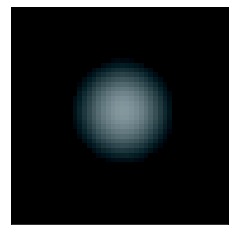

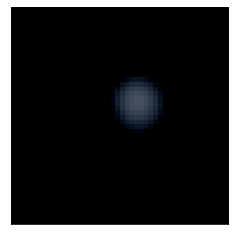

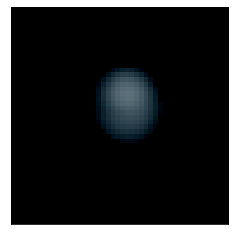

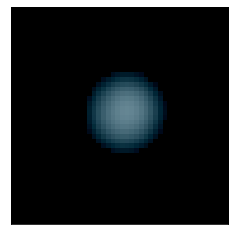

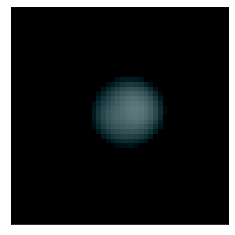

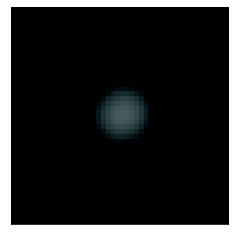

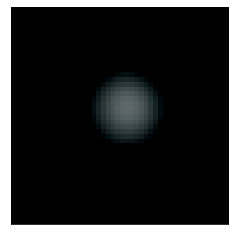

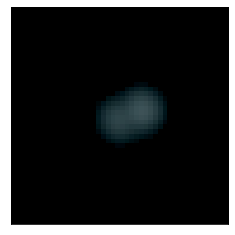

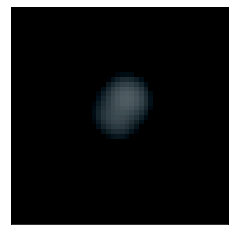

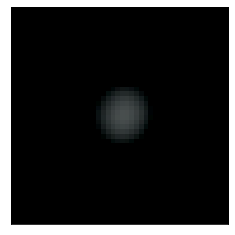

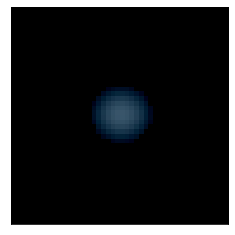

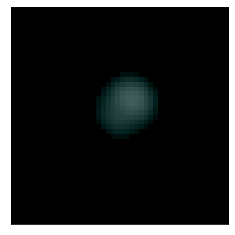

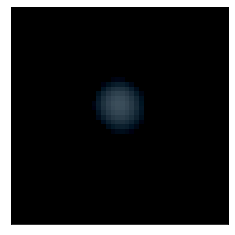

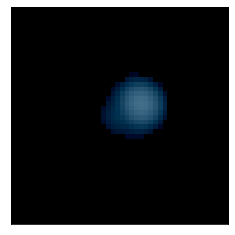

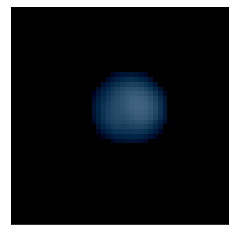

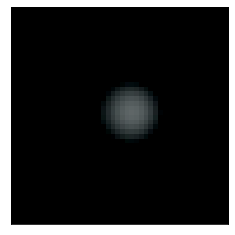

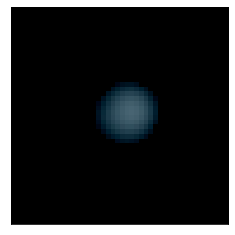

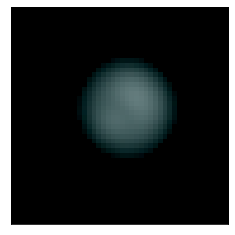

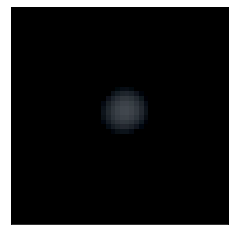

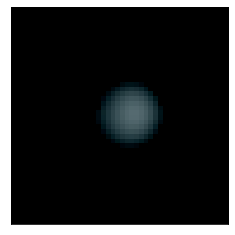

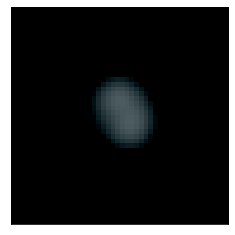

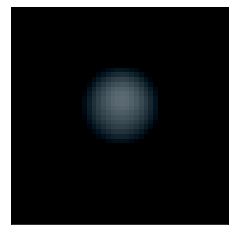

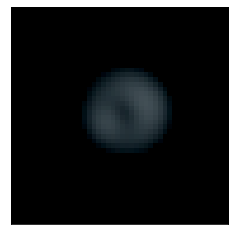

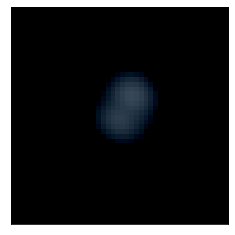

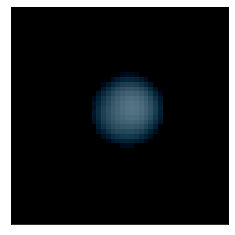

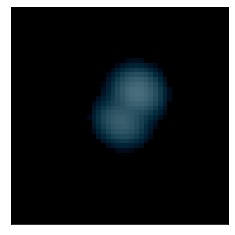

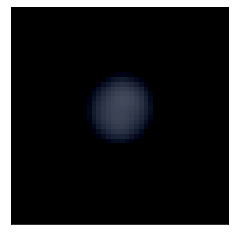

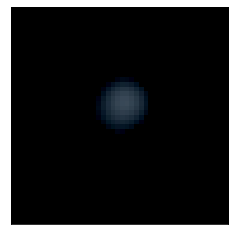

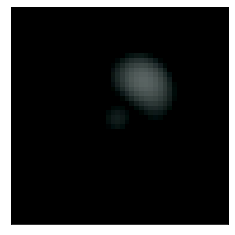

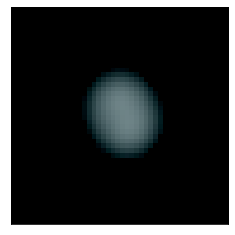

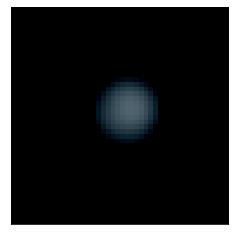

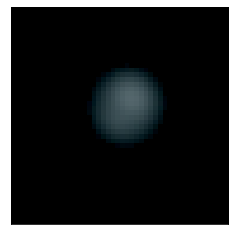

In [9]:
bell -n notify simulations_from_data(500, False)

In [10]:
bell -n say

In [11]:
#! convert -delay 50 -loop 0 *.png Only_sources_data.gif
#! rm *.png